
Mutual Information Scores (sorted):
f1: 0.0701
f7: 0.0668
f8: 0.0552
f4: 0.0457
f10: 0.0382
f5: 0.0206
f6: 0.0180
f3: 0.0143
f2: 0.0138
f9: 0.0083


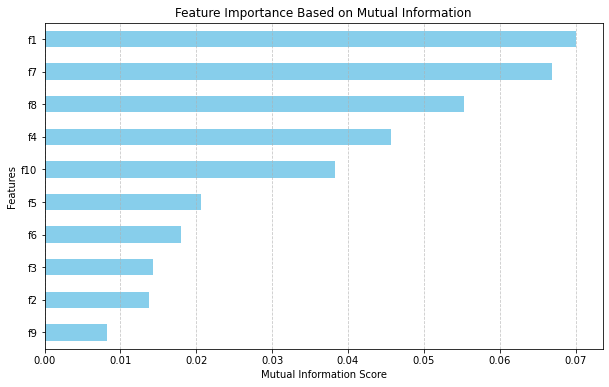


Best Feature Selected: f1 with score: 0.0701
Training Random Forest...
Best parameters for Random Forest: {'n_estimators': 150, 'max_depth': 10}
Cross-validation accuracy for Random Forest: 71.40% ± 1.59%
Training Gradient Boosting...
Best parameters for Gradient Boosting: {'n_estimators': 50, 'learning_rate': 0.2}
Cross-validation accuracy for Gradient Boosting: 70.64% ± 1.55%
Training XGBoost...
Best parameters for XGBoost: {'n_estimators': 150, 'learning_rate': 0.01}
Cross-validation accuracy for XGBoost: 70.81% ± 2.13%
Training Adaboost...
Best parameters for Adaboost: {'n_estimators': 150, 'learning_rate': 0.2}
Cross-validation accuracy for Adaboost: 70.19% ± 1.54%
Training SVM (RBF Kernel)...
Best parameters for SVM (RBF Kernel): {'gamma': 0.1, 'C': 1}
Cross-validation accuracy for SVM (RBF Kernel): 70.95% ± 0.90%
Training SVM (Polynomial Kernel)...
Best parameters for SVM (Polynomial Kernel): {'degree': 3, 'C': 10}
Cross-validation accuracy for SVM (Polynomial Kernel): 66.11% ±

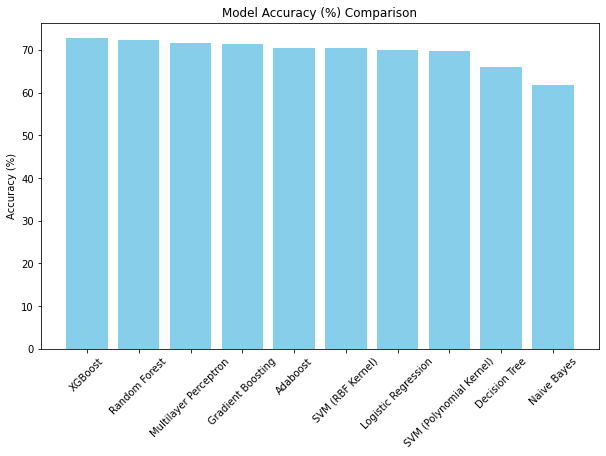

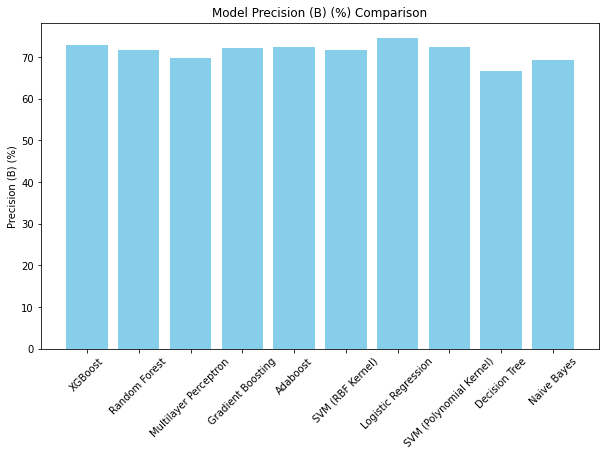

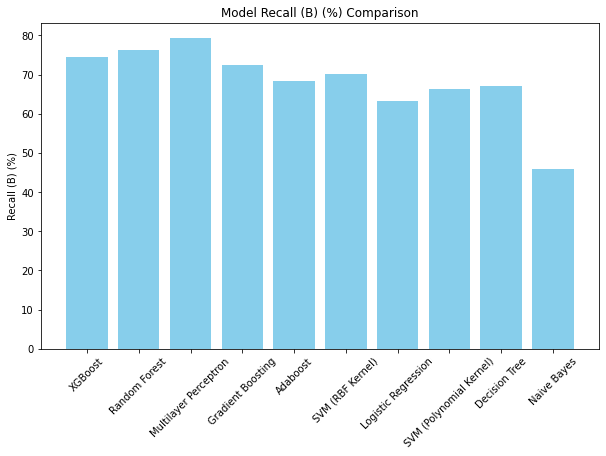

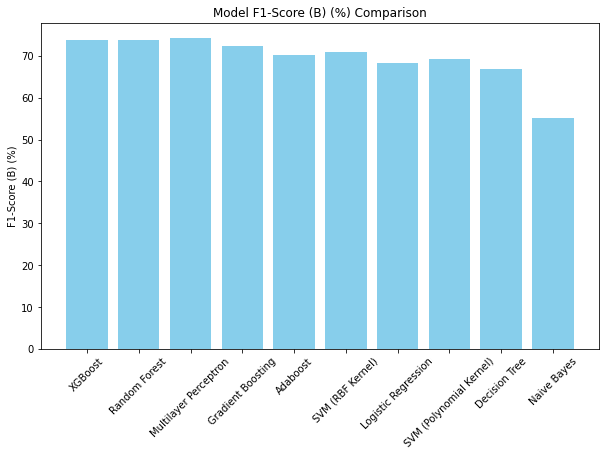

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Set random seed for reproducibility
RANDOM_SEED = 520  # My birthday
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Load datasets
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Separate features and target variable
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert ['B', 'NB'] to [0, 1]
y_test = label_encoder.transform(y_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using mutual information
mutual_info = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_SEED)
feature_importance = pd.Series(mutual_info, index=train_data.columns[:-1]).sort_values(ascending=False)

# Print feature importance scores
print("\nMutual Information Scores (sorted):")
for feature, score in feature_importance.items():
    print(f"{feature}: {score:.4f}")

# Visualize mutual information scores for all features
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title("Feature Importance Based on Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Select the best feature
best_feature = feature_importance.idxmax()
print(f"\nBest Feature Selected: {best_feature} with score: {feature_importance.max():.4f}")

# Define hyperparameter grids for all models
param_grids = {
    "Random Forest": {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]},
    "Gradient Boosting": {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    "XGBoost": {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    "Adaboost": {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    "SVM (RBF Kernel)": {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    "SVM (Polynomial Kernel)": {'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
    "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
    "Decision Tree": {'max_depth': [None, 10, 20], 'criterion': ['gini', 'entropy']},
    "Multilayer Perceptron": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 
                              'activation': ['relu', 'tanh'], 
                              'learning_rate_init': [0.001, 0.01]},
    "Naive Bayes": {}  # No hyperparameters to tune for GaussianNB
}

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "Adaboost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "SVM (Polynomial Kernel)": SVC(kernel='poly', probability=True),
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=RANDOM_SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000, early_stopping=True, random_state=RANDOM_SEED),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
results = []  # To store results for each model
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)  # Cross-validation with fixed random state

for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name in param_grids and param_grids[model_name]:  # Check if hyperparameter grid exists
        param_space_size = np.prod([len(v) for v in param_grids[model_name].values()])
        n_iter = min(10, param_space_size)  # Limit the number of iterations
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grids[model_name], n_iter=n_iter,
            cv=cv, scoring='accuracy', random_state=RANDOM_SEED, n_jobs=-1
        )
        random_search.fit(X_train_scaled, y_train)
        best_model = random_search.best_estimator_
        print(f"Best parameters for {model_name}: {random_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
        print(f"{model_name} does not have hyperparameters tuned.")

    # Cross-validation on training data
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation accuracy for {model_name}: {cv_scores.mean() * 100:.2f}% ± {cv_scores.std() * 100:.2f}%")

    # Evaluate on test data
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred) * 100
    classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

    # Save the results to the list
    results.append({
        "Model": model_name,
        "Accuracy (%)": accuracy,
        "Precision (B) (%)": classification["B"]["precision"] * 100,
        "Recall (B) (%)": classification["B"]["recall"] * 100,
        "F1-Score (B) (%)": classification["B"]["f1-score"] * 100,
        "Precision (NB) (%)": classification["NB"]["precision"] * 100,
        "Recall (NB) (%)": classification["NB"]["recall"] * 100,
        "F1-Score (NB) (%)": classification["NB"]["f1-score"] * 100
    })

# Display results as a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy (%)", ascending=False)
print("\nModel Performance Summary (as a table):")
print(results_df.to_string(index=False, float_format="%.2f"))

# Visualize model performance with bar plots for multiple metrics
metrics = ["Accuracy (%)", "Precision (B) (%)", "Recall (B) (%)", "F1-Score (B) (%)"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Model'], results_df[metric], color='skyblue')
    plt.ylabel(metric)
    plt.title(f"Model {metric} Comparison")
    plt.xticks(rotation=45)
    plt.show()